In [2]:
%matplotlib inline
%run 'notebook_utils.py'

import sys
import pprint
import cProfile

import matplotlib.pyplot as plt
import numpy             as np

import radical.utils     as ru
import radical.pilot     as rp
import radical.analytics as ra

from   radical.utils.profile import *
from   radical.pilot.states  import *

In [3]:
# Load wrangled data saved in .csv files for both synapse, microbenchmarks and gromacs.
esm_sessions = pd.read_csv('../esmacs/sessions.csv', index_col=0)
esm_pilots = pd.read_csv('../esmacs/pilots.csv', index_col=0)
esm_units = pd.read_csv('../esmacs/units.csv', index_col=0)

In [4]:
print 'Synapse: Weak Scaling: Total number of successful runs: %s' % esm_sessions.shape[0]
print 'Synapse: Weak Scaling: Total number of pilots: %s' % esm_pilots.shape[0]
print 'Synapse: Weak Scaling: Total number of units: %s\n' % esm_units.shape[0]

Synapse: Weak Scaling: Total number of successful runs: 6
Synapse: Weak Scaling: Total number of pilots: 6
Synapse: Weak Scaling: Total number of units: 2800



## Weak Scaling Results on Blue Waters (ESMACS only)

In [5]:
esms = esm_sessions[
    ['nunit','TTC','P_LRMS_QUEUING','U_AGENT_QUEUING','U_AGENT_SCHEDULING','U_AGENT_QUEUING_EXEC','U_AGENT_EXECUTING', 'util_u_pre_exec',
    'util_u_eprep','util_u_equeue','util_u_exec_cu','util_u_exec_rp']
        ].groupby(['nunit']).aggregate(
                {'TTC'                 : ['mean','std'],
                 'P_LRMS_QUEUING'      : ['mean','std'],
                 'U_AGENT_QUEUING'     : ['mean','std'],
                 'U_AGENT_SCHEDULING'  : ['mean','std'],
                 'U_AGENT_QUEUING_EXEC': ['mean','std'],
                 'U_AGENT_EXECUTING'   : ['mean','std'],
                 'util_u_pre_exec'     : ['mean','std'],
                 'util_u_eprep'        : ['mean','std'],
                 'util_u_equeue'       : ['mean','std'],
                 'util_u_exec_cu'      : ['mean','std'],
                 'util_u_exec_rp'      : ['mean','std'],
                 'util_u_pre_exec'     : ['mean','std']})

esms.rename({'util_u_eprep'        :'cu_prep'}, axis='columns', inplace=True)
esms.rename({'util_u_equeue'       :'scheduler_queue_cu'}, axis='columns', inplace=True)
esms.rename({'util_u_exec_cu'      :'os_spawns_cu'}, axis='columns', inplace=True)
esms.rename({'util_u_exec_rp'      :'executor_spawning_cu'}, axis='columns', inplace=True)
esms.rename({'util_u_pre_exec'     :'pre_executables_cu'}, axis='columns', inplace=True)

esms.rename({'P_LRMS_QUEUING'      :'TTQ'}, axis='columns', inplace=True)
esms.rename({'U_AGENT_QUEUING'     :'agent_queueing'}, axis='columns', inplace=True)
esms.rename({'U_AGENT_SCHEDULING'  :'agent_scheduling'}, axis='columns', inplace=True)
esms.rename({'U_AGENT_QUEUING_EXEC':'agent_queue_exec'}, axis='columns', inplace=True)
esms.rename({'U_AGENT_EXECUTING'   :'TTX'}, axis='columns', inplace=True)

esms.rename(index={i: '%s/%s' % (i/(25*4), i*8) for i in esms.index.get_values()}, inplace=True)
esms

executor_spawning_cu           agent_queueing           pre_executables_cu             cu_prep           os_spawns_cu              ...             TTQ               agent_queue_exec                   TTX                       TTC                scheduler_queue_cu          
                       mean       std           mean       std               mean       std      mean       std         mean       std    ...            mean           std             mean       std        mean         std          mean            std               mean       std
nunit                                                                                                                                     ...                                                                                                                                           
2/1600            19.369100  8.774489       0.391500  0.122330          21.276499  7.947174  1.913800  0.174795    22.521950  7.958981    ...     26396.78365  34779.816577         9.705650  2.832600  3989.55525  205.829380  1.522674e+09   46899.585441           10.09645  2.839811
4/3200            30.395402  4.206014       0.794652  0.079406          29.972850  4.581555  4.259898  0.072832    31.901449  4.698087    ...     24426.49735   9545.612246        19.168351  0.492358  3440.22060   69.567569  1.522281e+09  508274.716793           19.95205  0.547229
8/6400            67.676700  1.520845       2.181499  0.248902          66.854448  1.914349  9.347847  2.202284    70.934501  2.188918    ...     11431.75640   1362.262144        36.666601  1.312674  3322.68820   67.288706  1.522710e+09   21993.711083           39.24715  1.339334

[3 rows x 22 columns]

In [6]:
esmp = esm_pilots[
    ['nunit','util_p_total','util_p_boot','util_p_term','util_p_uexec']
        ].groupby(['nunit']).aggregate(
                {'util_p_total'        : ['mean','std'],
                 'util_p_boot'         : ['mean','std'],
                 'util_p_term'         : ['mean','std'],
                 'util_p_uexec'        : ['mean','std']})


# 'orte_dvm_start'  is not captured in APRUN

esmp.rename({'util_p_total'        :'p_total'}, axis='columns', inplace=True)
esmp.rename({'util_p_boot'         :'p_bootstraps'}, axis='columns', inplace=True)
esmp.rename({'util_p_term'         :'p_term'}, axis='columns', inplace=True)
esmp.rename({'util_p_uexec'        :'p_uexec'}, axis='columns', inplace=True)

esmp.rename(index={i: '%s/%s' % (i/(25*4), i*8) for i in esmp.index.get_values()}, inplace=True)
esmp

p_term                p_uexec                 p_total             p_bootstraps           
            mean        std        mean         std        mean         std         mean        std
nunit                                                                                              
2/1600  13.60170  11.643927  4014.66685  205.843946  4100.12920  160.867217     66.33885  34.292063
4/3200   7.22210   0.131239  3466.92300   71.583814  3525.23220   74.572330     44.17350   2.208860
8/6400   6.98235   0.980404  3347.59975   67.844986  3403.94925   63.149090     42.80805   1.663045

In [8]:
# Create dict of <sid> and <nunit>
# Get what each event does from --> https://github.com/radical-experiments/rp.paper/blob/master/analysis/rp_paper_utilization.ipynb

# Can get events from both sws_sessions and sws_units (in case of units):

# 'u_equeue'    : 'SchedulerQueing CU',
# 'u_eprep'     : '* CU preparation',
# 'u_exec_rp'   : 'Executor Spawning CU',
# 'u_exec_cu'   : 'OS Spawning CU',
# 'u_exec_orte' : '* CU execution (ORTE)',
# 'u_exec_app'  : 'Executable Executing',
# 'u_unschedule': '? Scheduler Unscheduling',


keys = esm_sessions['sid'].tolist()
values = esm_sessions['nunit'].tolist()
nunits_dict = dict(zip(keys, values))

sids_list = esm_units['sid'].tolist()
nunit = []

for i in sids_list:
    nunit.append(nunits_dict[i])

esm_units['nunit']=nunit
esm_units.set_index('sid')
esmu = esm_units[
    ['nunit','util_u_eprep','util_u_equeue','util_u_exec_cu','util_u_exec_rp','util_u_pre_exec']
        ].groupby(['nunit']).aggregate(
                {'util_u_eprep'          : ['mean','std'],
                 'util_u_equeue'         : ['mean','std'],
                 'util_u_exec_cu'        : ['mean','std'],
                 'util_u_exec_rp'        : ['mean','std'],
                 'util_u_pre_exec'       : ['mean','std']})

esmu.rename({'util_u_eprep'        :'cu_prep'}, axis='columns', inplace=True)
esmu.rename({'util_u_equeue'       :'scheduler_queue_cu'}, axis='columns', inplace=True)
esmu.rename({'util_u_exec_cu'      :'os_spawns_cu'}, axis='columns', inplace=True)
esmu.rename({'util_u_exec_rp'      :'executor_spawning_cu'}, axis='columns', inplace=True)
esmu.rename({'util_u_pre_exec'     :'pre_executables_cu'}, axis='columns', inplace=True)

esmu.rename(index={i: '%s/%s' % (i/(25*4), i*8) for i in esmu.index.get_values()}, inplace=True)
esmu


cu_prep           executor_spawning_cu           scheduler_queue_cu           pre_executables_cu           os_spawns_cu          
            mean       std                 mean       std               mean       std               mean       std         mean       std
nunit                                                                                                                                     
2/1600  0.009569  0.008603             0.182459  0.146854           0.139572  0.164196           0.214687  0.204864     0.239959  0.209698
4/3200  0.010650  0.027659             0.130596  0.120235           0.234955  0.343767           0.125467  0.134349     0.145429  0.137411
8/6400  0.011685  0.034614             0.142685  0.124433           0.138871  0.166521           0.140169  0.145722     0.158829  0.146888

/Users/JumanaDakka/environments/pypi_venv/lib/python2.7/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


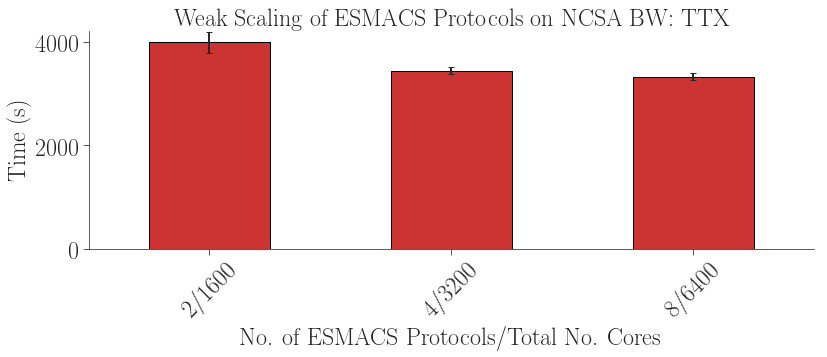

In [9]:
fig, ax = fig_setup(figsize=(13,4))

# Plot means and std bars
# sws['TTC'].reset_index().plot.bar(
#     x='nunit', y='mean', yerr='std',
#     position=1.5, width=0.25, color=tableau20[1], ax=ax, rot=45,
#     legend=False)

# sws['TTQ'].reset_index().plot.bar(
#     x='nunit', y='mean', yerr='std',
#     position=0.5, width=0.25, color=tableau20[3], ax=ax, rot=45,
#     legend=False)

ax = esms['TTX'].reset_index().plot.bar(
    x='nunit', y='mean', yerr='std', 
    width=0.5, color=tableau20[6], ax=ax, rot=45, # position=-0.5, secondary_y=True,
    title='Weak Scaling of ESMACS Protocols on NCSA BW: TTX',
    legend=False)


ax.set_xlabel('No. of ESMACS Protocols/Total No. Cores')
ax.set_ylabel('Time (s)')
ax.set_ylim(0,4200)
ax.set_xlim(-0.5)


plt.savefig('figures/ties_NCSA_BW_weak_scaling_ESMACS.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/ties_NCSA_BW_weak_scaling_ESMACS.png')

In [9]:
# ------------------------------------------------------------------------------
#
# absolute utilization: number of core hours per activity
# relative utilization: percentage of total pilot core hours
#
ABSOLUTE = False


# ------------------------------------------------------------------------------
#
# pilot and unit activities: core hours are derived by multiplying the
# respective time durations with pilot size / unit size.  The 'idle' utilization
# and the 'agent' utilization are derived separately.
#
# Note that durations should add up to the `x_total` generations to ensure
# accounting for the complete unit/pilot utilization.
#
PILOT_DURATIONS = {
        'p_total'     : [{STATE: None,            EVENT: 'bootstrap_1_start'},
                         {STATE: None,            EVENT: 'bootstrap_1_stop' }],

        'p_boot'      : [{STATE: None,            EVENT: 'bootstrap_1_start'},
                         {STATE: None,            EVENT: 'sync_rel'         }],
#         'p_setup_1'   : [{STATE: None,            EVENT: 'sync_rel'         },
#                          {STATE: None,            EVENT: 'orte_dvm_start'   }],
#         'p_orte'      : [{STATE: None,            EVENT: 'orte_dvm_start'   },
#                          {STATE: None,            EVENT: 'orte_dvm_ok'      }],
#         'p_setup_2'   : [{STATE: None,            EVENT: 'orte_dvm_ok'      },
#                          {STATE: PMGR_ACTIVE,     EVENT: 'state'            }],
        'p_uexec'     : [{STATE: PMGR_ACTIVE,     EVENT: 'state'            },
                         {STATE: None,            EVENT: 'cmd'              }],
        'p_term'      : [{STATE: None,            EVENT: 'cmd'              },
                         {STATE: None,            EVENT: 'bootstrap_1_stop' }]}

UNIT_DURATIONS = {
        'u_total'     : [{STATE: None,            EVENT: 'schedule_ok'      },
                         {STATE: None,            EVENT: 'unschedule_stop'  }],

        'u_equeue'    : [{STATE: None,            EVENT: 'schedule_ok'      },
                         {STATE: AGENT_EXECUTING, EVENT: 'state'            }],
        'u_eprep'     : [{STATE: AGENT_EXECUTING, EVENT: 'state'            },
                         {STATE: None,            EVENT: 'exec_start'       }],
        'u_exec_rp'   : [{STATE: None,            EVENT: 'exec_start'       },
                         {STATE: None,            EVENT: 'cu_start'         }],
        'u_exec_cu'   : [{STATE: None,            EVENT: 'cu_start'         },
                         {STATE: None,            EVENT: 'cu_exec_start'    }]}
        #'u_exec_orte' : [{STATE: None,            EVENT: 'cu_exec_start'    },
#                          {STATE: None,            EVENT: 'app_start'        }],
        #'u_exec_app'  : [{STATE: None,            EVENT: 'app_start'        },
#                          {STATE: None,            EVENT: 'app_stop'         }],
        #'u_unschedule': [{STATE: None,            EVENT: 'app_stop'         },
#                          {STATE: None,            EVENT: 'unschedule_stop'  }]}

DERIVED_DURATIONS = ['p_agent', 'p_idle', 'p_setup']

TRANSLATE_KEYS    = {
                     'p_agent'     : '* agent nodes',
                     'p_boot'      : '* pilot bootstrap',
                     #'p_setup'     : '* pilot setup',
                     #'p_orte'      : '* orte  setup',
                     'p_term'      : '* pilot termination',
                     'p_idle'      : '* pilot idle',

                     'u_equeue'    : 'SchedulerQueing CU',
                     'u_eprep'     : '* CU preparation',
                     'u_exec_rp'   : 'Executor Spawning CU',
                     'u_exec_cu'   : 'OS Spawning CU',
                     'u_pre_exec'   : 'CU pre-exec',
                     #'u_exec_orte' : '* CU execution (ORTE)',
                     #'u_exec_app'  : 'Executable Executing',
                     #'u_unschedule': '? Scheduler Unscheduling',
    
                     'rp_overhead' : 'RP Overhead', 
                     'rp_busy'     : 'Workload Execution',
                     'rp_idle'     : 'RP Idle',
#                      'rp_orte'     : 'RP ORTE', 
                     'rp_scheduler': 'RP Scheduler'
                    }

  # # Durations sub-component level
  # df['Scheduler Scheduling']   = df['Scheduler Stops Schedule']   - df['Scheduler Starts Schedule']
  # df['Scheduler Queuing CU']   = df['Executor Starts']            - df['Scheduler Queues CU']
  # df['Executor Starting']      = df['Executor Starts Mkdir']      - df['Executor Starts']
  # df['Executor Making Dir']    = df['Executor Stops Mkdir']       - df['Executor Starts Mkdir']
  # df['Executor Spawning CU']   = df['OS Accepts Spawned CU']      - df['Executor Spawns CU']
  # df['OS Spawning CU']         = df['OS Spawns CU']               - df['OS Accepts Spawned CU']
  # df['CU Changing Dir']        = df['CU Changes Dir']             - df['OS Spawns CU']
  # df['CU Pre-executing']       = df['CU Stops Pre-execute']       - df['CU Starts Pre-execute']
  # df['CU Spawning Executable'] = df['Executable Starts']          - df['CU Spawns Executable']
  # df['Executable Executing']   = df['Executable Stops']           - df['Executable Starts']
  # df['CU Post-executing']      = df['CU Stops Post-execute']      - df['CU Starts Post-execute']
  # df['Executor Stopping']      = df['Executor Stops']             - df['CU Stops Post-execute']
  # df['Scheduler Unscheduling'] = df['Scheduler Stops Unschedule'] - df['Scheduler Starts Unschedule']


# there must be a better way to do this...
_ORIGINAL_ORDERED_KEYS      = [
                     'p_boot',
                     #'p_setup',
                     #'p_orte',
                     'u_equeue',
                     'u_eprep',
                     'u_exec_rp',
                     'u_exec_cu',
                     #'u_exec_orte',
                     #'u_exec_app',
                     #'u_unschedule',
                     'p_idle',
                     'p_term',
                     'p_agent',
                     ]


ORDERED_KEYS = ['cu_prep',
                'scheduler_queue_cu',
                'os_spawns_cu',
                'executor_spawning_cu',
                'p_bootstraps',
                'p_term'] 


In [10]:
frames = [esms, esmp]
data = pd.concat(frames, axis=1)
data 

executor_spawning_cu           agent_queueing           pre_executables_cu             cu_prep           os_spawns_cu              ...     scheduler_queue_cu              p_term                p_uexec                 p_total             p_bootstraps           
                       mean       std           mean       std               mean       std      mean       std         mean       std    ...                   mean       std      mean        std        mean         std        mean         std         mean        std
nunit                                                                                                                                     ...                                                                                                                              
2/1600            19.369100  8.774489       0.391500  0.122330          21.276499  7.947174  1.913800  0.174795    22.521950  7.958981    ...               10.09645  2.839811  13.60170  11.643927  4014.66685  205.843946  4100.12920  160.867217     66.33885  34.292063
4/3200            30.395402  4.206014       0.794652  0.079406          29.972850  4.581555  4.259898  0.072832    31.901449  4.698087    ...               19.95205  0.547229   7.22210   0.131239  3466.92300   71.583814  3525.23220   74.572330     44.17350   2.208860
8/6400            67.676700  1.520845       2.181499  0.248902          66.854448  1.914349  9.347847  2.202284    70.934501  2.188918    ...               39.24715  1.339334   6.98235   0.980404  3347.59975   67.844986  3403.94925   63.149090     42.80805   1.663045

[3 rows x 30 columns]

(-0.5, 2.5)

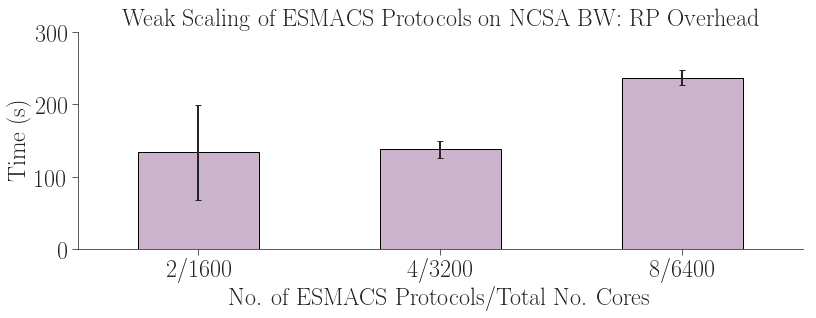

In [20]:
fig, ax = fig_setup(figsize=(13,4))

RP_OVERHEAD_ws = data['cu_prep'] + data['scheduler_queue_cu'] + data['os_spawns_cu'] + data['executor_spawning_cu'] + data['p_bootstraps'] + data['p_term'] 

TOTAL_TTX_ws = esms['TTX'] + data['pre_executables_cu']

ax = RP_OVERHEAD_ws.reset_index().plot.bar(
    x='nunit', y='mean', yerr='std', 
    width=0.5, color=tableau20[9], ax=ax, rot=0, # position=-0.5, secondary_y=True,
    title='Weak Scaling of ESMACS Protocols on NCSA BW: RP Overhead',
    legend=False)


ax.set_xlabel('No. of ESMACS Protocols/Total No. Cores')
ax.set_ylabel('Time (s)')
ax.set_ylim(0,300)
ax.set_xlim(-0.5)

(-0.5, 2.5)

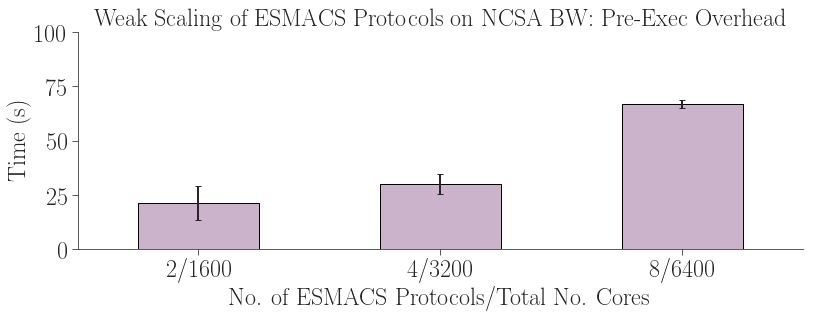

In [21]:
fig, ax = fig_setup(figsize=(13,4))

pre_exec = data['pre_executables_cu']


ax = pre_exec.reset_index().plot.bar(
    x='nunit', y='mean', yerr='std', 
    width=0.5, color=tableau20[9], ax=ax, rot=0, # position=-0.5, secondary_y=True,
    title='Weak Scaling of ESMACS Protocols on NCSA BW: Pre-Exec Overhead',
    legend=False)


ax.set_xlabel('No. of ESMACS Protocols/Total No. Cores')
ax.set_ylabel('Time (s)')
ax.set_ylim(0,100)
ax.set_xlim(-0.5)

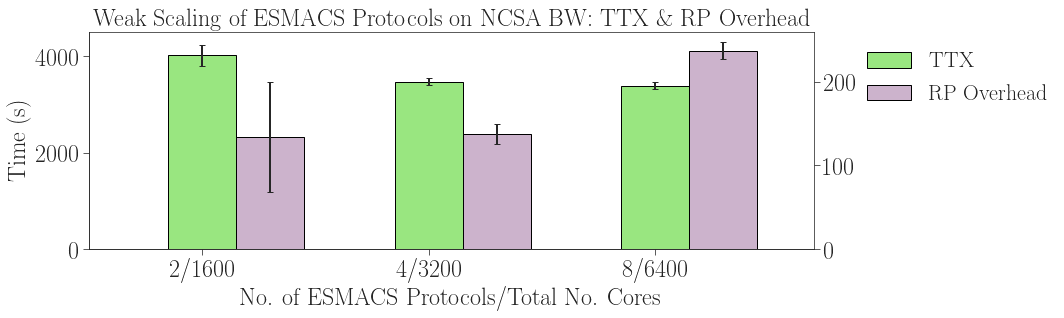

In [24]:
fig, ax = fig_setup(figsize=(13,4))
width = 0.3


ax = TOTAL_TTX_ws.reset_index().plot(kind='bar',
    x='nunit', y='mean', yerr='std', 
    color=tableau20[5], width=width, ax=ax, rot=45, # position=-0.5, secondary_y=True,
    title='Weak Scaling of ESMACS Protocols on NCSA BW: TTX \& RP Overhead',
    legend=False)

ax.set_xlabel('No. of ESMACS Protocols/Total No. Cores')
ax.set_ylabel('Time (s)')
ax.set_ylim(0,4500)
ax.set_xlim(-0.5)

ax2 = RP_OVERHEAD_ws.reset_index().plot(kind='bar',
    x='nunit', y='mean', yerr='std', 
    color=tableau20[9], width=width, ax=ax, rot=0, position=-0.5, secondary_y=True,
    legend=False)

#ax.set_ylim(0,300)
ax.set_xlim(-0.5)
ax.set_xlabel('No. of ESMACS Protocols/Total No. Cores')

ax.legend(["TTX"], bbox_to_anchor = (1.247,1))
ax2.legend(["RP Overhead"], bbox_to_anchor = (1.35,0.85))

plt.savefig('figures/ESMACS_NCSA_BW_weak_scaling_with_overhead.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/ESMACS_NCSA_BW_weak_scaling_with_overhead.png')

In [14]:
RP_OVERHEAD_ws

,mean,std
nunit,,
2/4160,191.698901,9.789757
4/8320,371.482100,20.736473
8/16640,839.571996,36.572124


# Strong Scaling Results on Blue Waters

In [15]:
ssc = ssc_sessions[
    ['ncore','TTC','P_LRMS_QUEUING','U_AGENT_QUEUING','U_AGENT_SCHEDULING','U_AGENT_QUEUING_EXEC','U_AGENT_EXECUTING', 'util_u_eprep',
    'util_u_equeue','util_u_exec_cu','util_u_exec_rp', 'util_u_pre_exec']
        ].groupby(['ncore']).aggregate(
                {'TTC'                 : ['mean','std'],
                 'P_LRMS_QUEUING'      : ['mean','std'],
                 'U_AGENT_QUEUING'     : ['mean','std'],
                 'U_AGENT_SCHEDULING'  : ['mean','std'],
                 'U_AGENT_QUEUING_EXEC': ['mean','std'],
                 'U_AGENT_EXECUTING'   : ['mean','std'],
                 'util_u_eprep'        : ['mean','std'],
                 'util_u_equeue'       : ['mean','std'],
                 'util_u_exec_cu'      : ['mean','std'],
                 'util_u_exec_rp'      : ['mean','std'],
                 'util_u_pre_exec'     : ['mean','std']})


            
ssc.rename({'util_u_eprep'        :'cu_prep'}, axis='columns', inplace=True)
ssc.rename({'util_u_equeue'       :'scheduler_queue_cu'}, axis='columns', inplace=True)
ssc.rename({'util_u_exec_cu'      :'os_spawns_cu'}, axis='columns', inplace=True)
ssc.rename({'util_u_exec_rp'      :'executor_spawning_cu'}, axis='columns', inplace=True)
ssc.rename({'util_u_exec_rp'      :'executor_spawning_cu'}, axis='columns', inplace=True)
ssc.rename({'util_u_pre_exec'     :'pre_executables_cu'}, axis='columns', inplace=True)

ssc.rename({'P_LRMS_QUEUING'      :'TTQ'}, axis='columns', inplace=True)
ssc.rename({'U_AGENT_QUEUING'     :'Agent queueing'}, axis='columns', inplace=True)
ssc.rename({'U_AGENT_SCHEDULING'  :'Agent scheduling'}, axis='columns', inplace=True)
ssc.rename({'U_AGENT_QUEUING_EXEC':'Agent queueing execution'}, axis='columns', inplace=True)
ssc.rename({'U_AGENT_EXECUTING'   :'TTX'}, axis='columns', inplace=True)
ssc.rename(index={i: '%s/%s' % (ssc_sessions[ssc_sessions.ncore == i].nunit[0]/(65*4), i) for i in ssc.index.get_values()}, 
           inplace=True)
ssc

executor_spawning_cu            Agent queueing           pre_executables_cu               cu_prep            os_spawns_cu               ...              TTQ                Agent queueing execution                    TTX                       TTC               scheduler_queue_cu           
                        mean        std           mean       std               mean        std       mean        std         mean        std    ...             mean            std                     mean        std        mean         std          mean           std               mean        std
ncore                                                                                                                                           ...                                                                                                                                                      
8/4160            189.210402  53.678598       4.026451  0.358574         214.417155  50.225718  23.195800   1.938042   229.320951  44.613132    ...       54615.3124   57418.104988                64.620897  26.219948  8400.71615  184.511100  1.518513e+09  3.132454e+06          72.502650  25.575704
8/8320            300.577898  38.420082      11.763355  9.516458         304.574900  29.831281  72.730798  64.527885   308.773100  29.060534    ...      187590.7861  198391.997549               176.523704  80.578209  4357.21100   78.303591  1.517651e+09  3.012034e+06         182.749653  77.846729
8/16640           200.256801   6.026953      10.942751  0.193111         208.392899   9.132990  28.031697   3.131780   212.703200   9.098201    ...        5322.4127    4926.340537               133.541199   3.950323  2372.45005    0.624446  1.514527e+09  1.087197e+04         141.211250   3.549458

[3 rows x 22 columns]

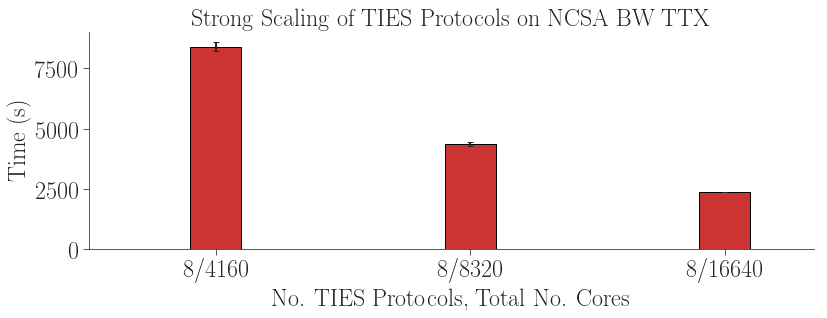

In [16]:
fig, ax = fig_setup(figsize=(13,4))

ax = ssc['TTX'].reset_index().plot.bar(
    x='ncore', y='mean', yerr='std', 
    # position=-0.5, 
    width=0.2, color=tableau20[6], ax=ax, rot=0,
    title='Strong Scaling of TIES Protocols on NCSA BW TTX',
    # secondary_y=True, 
    legend=False)


ax.set_xlabel('No. TIES Protocols, Total No. Cores')
ax.set_ylabel('Time (s)')
ax.set_ylim(0)
ax.set_xlim(-0.5)

plt.savefig('figures/ties_NCSA_BW_strong_scaling.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/ties_NCSA_BW_strong_scaling.png')

In [17]:
pss = ssc_pilots[
    ['ncore','util_p_total','util_p_boot','util_p_term','util_p_uexec']
        ].groupby(['ncore']).aggregate(
                {'util_p_total'        : ['mean','std'],
                 'util_p_boot'         : ['mean','std'],
                 'util_p_term'         : ['mean','std'],
                 'util_p_uexec'        : ['mean','std']})


# 'orte_dvm_start'  is not captured in APRUN

pss.rename({'util_p_total'        :'p_total'}, axis='columns', inplace=True)
pss.rename({'util_p_boot'         :'p_bootstraps'}, axis='columns', inplace=True)
pss.rename({'util_p_term'         :'p_term'}, axis='columns', inplace=True)
pss.rename({'util_p_uexec'        :'p_uexec'}, axis='columns', inplace=True)
pss.rename(index={i: '%s/%s' % (ssc_sessions[ssc_sessions.ncore == i].nunit[0]/(65*4), i) for i in pss.index.get_values()}, 
           inplace=True)
pss

p_term               p_uexec                 p_total             p_bootstraps           
            mean       std        mean         std        mean         std         mean        std
ncore                                                                                             
8/4160   6.99915  0.717926  8443.36965  188.105748  8491.66075  178.031598     37.70665   8.723647
8/8320   9.40820  2.207446  4438.57795   27.130485  4536.62910   80.590374     80.69600  44.282279
8/16640  7.40790  1.818820  2533.82360  163.762819  2586.50705  162.062723     41.56825   3.813922

In [19]:
RP_OVERHEAD_ss = ssc['pre_executables_cu'] + ssc['cu_prep'] + ssc['scheduler_queue_cu'] + ssc['os_spawns_cu'] + ssc['executor_spawning_cu']  + pss['p_bootstraps'] + pss['p_term'] 
RP_OVERHEAD_ss 

,mean,std
ncore,,
8/4160,773.352758,185.472766
8/8320,1259.510548,286.176237
8/16640,839.571996,36.572124


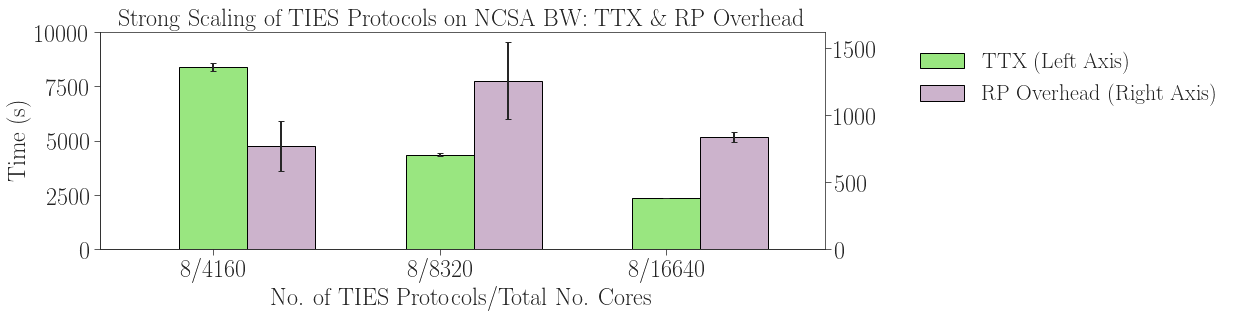

In [32]:
fig, ax = fig_setup(figsize=(13,4))
width = 0.3


ax = ssc['TTX'].reset_index().plot(kind='bar',
    x='ncore', y='mean', yerr='std', 
    color=tableau20[5], width=width, ax=ax, rot=45, # position=-0.5, secondary_y=True,
    title='Strong Scaling of TIES Protocols on NCSA BW: TTX \& RP Overhead',
    legend=False)

ax.set_xlabel('No. of TIES Protocols/Total No. Cores')
ax.set_ylabel('Time (s)')
ax.set_ylim(0,10000)
ax.set_xlim(-0.5)

ax2 = RP_OVERHEAD_ss.reset_index().plot(kind='bar',
    x='ncore', y='mean', yerr='std', 
    color=tableau20[9], width=width, ax=ax, rot=0, position=-0.5, secondary_y=True,
    legend=False)

#ax.set_ylim(0,300)
ax.set_xlim(-0.5)
ax.set_xlabel('No. of TIES Protocols/Total No. Cores')

ax.legend(["TTX (Left Axis)"], bbox_to_anchor = (1.447,1))
ax2.legend(["RP Overhead (Right Axis)"], bbox_to_anchor = (1.569,0.85))

plt.savefig('figures/ties_NCSA_BW_strong_scaling_with_overhead.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/ties_NCSA_BW_strong_scaling_with_overhead.png')

In [21]:
TIES_16 = pd.read_csv('16_instances/sessions.csv', index_col=0)['nunit_failed']
print TIES_16 

TIES_8 = sws_sessions['nunit_failed']
TIES_8

rp.session.two.jdakka.017529.0016    1998
Name: nunit_failed, dtype: int64


rp.session.two.jdakka.017529.0014    236
rp.session.two.jdakka.017529.0001      0
rp.session.two.jdakka.017529.0006    284
rp.session.two.jdakka.017529.0013      0
rp.session.two.jdakka.017529.0003      0
rp.session.two.jdakka.017530.0028      0
Name: nunit_failed, dtype: int64

In [46]:
pd.DataFrame({'protocol instances': [8, 8, 16], 'no concurrent tasks': [520, 520, 1040], 'total no failed units': [236, 284, 1998], 'total no of tasks': [2080, 2080, 4160]}).set_index('protocol instances')


,no concurrent tasks,total no failed units,total no of tasks
protocol instances,,,
8,520,236,2080
8,520,284,2080
16,1040,1998,4160
